In [2]:
!python driver.py --alpha 1 --lamb 1e0 --backward 0 --nu 1e0 --steps 0 --steps_back 0 --bottleneck 16 --eta 1e2 --dataset climate --epochs 100 --batch 128 --folder results_climate --lr_update 15 35 50 70 100 200 --lr_decay 0.2 --print_every 1 --freq 10 --lr 5e-3 --lags 1 --plot_latent 0 --tropical 0 --start_year 1900 --scale 0.25

caled):  0.11994718760251999
loss sum:  0.11994718760251999
[0.9899999  0.9899999  0.98999995 0.98999995 0.9899998  0.9899998
 0.98999995 0.98999995 0.98999995 0.98999995 0.9899999  0.9899999
 0.9899999  0.9899999  0.9899998  0.9899998 ]
********** Epoch 41 **********
loss identity (actual):  0.1367041915655136
loss identity (scaled):  0.1367041915655136
loss sum:  0.1367041915655136
[0.9899999  0.9899999  0.98999995 0.98999995 0.9899998  0.9899998
 0.98999995 0.98999995 0.98999995 0.98999995 0.9899999  0.9899999
 0.9899999  0.9899999  0.9899998  0.9899998 ]
********** Epoch 42 **********
loss identity (actual):  0.11472896486520767
loss identity (scaled):  0.11472896486520767
loss sum:  0.11472896486520767
[0.9899999  0.9899999  0.98999995 0.98999995 0.9899998  0.9899998
 0.98999995 0.98999995 0.98999995 0.98999995 0.9899999  0.9899999
 0.9899999  0.9899999  0.9899998  0.9899998 ]
********** Epoch 43 **********
loss identity (actual):  0.10241654515266418
loss identity (scaled):  0.10

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
from torch.utils.data import DataLoader, Dataset

import torch.nn.init as init


import sys

sys.path.append('../src')
from read_dataset import data_from_name
from model import *
from tools import *
from train import *

import os

In [4]:
b = 16
alpha = 1
lags = 1
freq = 10
scale=0.25
Burgess= False
steps = 0

In [5]:


#******************************************************************************
# load data
#******************************************************************************
X, Xclean, m, n = data_from_name("climate", freq=1, start_year=1900, end_year= 2010, tropical=0, scale=scale)

print(type(X))
#******************************************************************************
# Reshape data for pytorch into 4D tensor Samples x Channels x Width x Height
#******************************************************************************
X = add_channels(X)


# transfer to tensor
X = torch.from_numpy(X).float().contiguous()


mean = torch.mean(X,dim=0)
# mean = torch.mean(X)
print(mean.shape)


X = (X-mean)
std = torch.std(X)
print(std)
X = (X)/ (std+1e-7) 

# Add lags

catDat = []
start = 0
for i in np.arange(lags-1,-1, -1):
    if i == 0:
        catDat.append(X[start*freq:].float())
    else:
        catDat.append(X[start*freq:-i*freq].float())
    start += 1
X = torch.cat(catDat,dim=2)
del(catDat)
print(X.shape)

#******************************************************************************
# Create Dataloader objects
#******************************************************************************
trainDat = []
start = 0
for i in np.arange(steps,-1, -1):
    if i == 0:
        trainDat.append(X[start*freq:].float())
    else:
        trainDat.append(X[start*freq:-i*freq].float())
    start += 1

train_data = torch.utils.data.TensorDataset(*trainDat)
del(trainDat)

# train_loader = DataLoader(dataset = train_data,
#                               batch_size = 64,
#                               shuffle = True)

<class 'numpy.ndarray'>
(40178, 18, 36)
<class 'numpy.ndarray'>
torch.Size([1, 18, 36])
tensor(6.7989)
torch.Size([40178, 1, 18, 36])


In [6]:
model_path = "results_climate/model_backward0.pkl"
# model_path = "results_climate/model4.pkl"
# m, n, b, steps, steps_back =
model = koopmanAE(m, n, lags, b, steps=steps, steps_back=0, alpha=alpha, Burgess=Burgess)
model.load_state_dict(torch.load(model_path))
model.eval()

koopmanAE(
  (encoder): encoderNet(
    (act): ReLU()
    (batch1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=648, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
    (fc4): Linear(in_features=32, out_features=16, bias=True)
    (fc5): Linear(in_features=16, out_features=16, bias=True)
  )
  (decoder): decoderNet(
    (act): ReLU()
    (fc1): Linear(in_features=16, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=648, bias=True)
  )
  (dynamics): dynamics(
    (dynamics): Linear(in_features=16, out_features=16, bias=False)
  )
  (backdynamics): dynamics_back(
    (dynamics): Linear(in_features=16, out_feat

In [107]:
print(train_data[:][0].shape)

torch.Size([40177, 1, 18, 36])


In [7]:
# del(train_loader)
with torch.no_grad():
    embedding= (model.encoder(train_data[:][0]))

embedding = np.reshape(embedding, newshape= (-1,b))
# del(train_data)

In [94]:
A =  model.dynamics.dynamics.weight.cpu().data.numpy()
w, v = np.linalg.eig(A)
print(np.abs(w))

projected = np.dot(embedding,v)


[0.9899999  0.9899999  0.98999995 0.98999995 0.98999995 0.98999995
 0.9899999  0.9899999 ]


In [48]:
print(A)

[[ 2.47884482e-01  2.06800044e-01  2.28283808e-01 -1.40443906e-01
   1.37905166e-01  1.42789036e-02  1.60037756e-01 -3.47243786e-01
  -2.58645236e-01 -1.99804142e-01  3.53144616e-01  2.81189054e-01
   2.38056481e-01 -2.22734109e-01  2.40038380e-01  6.40971512e-02
   1.88337013e-01 -2.44765669e-01  1.16437674e-01 -3.46545428e-01
   3.49028260e-02  1.79191921e-02 -7.65383244e-02  1.34013280e-01]
 [ 2.30837613e-01  2.48811379e-01 -2.16526940e-01 -2.66513765e-01
   2.03719869e-01  2.38175131e-02  1.21132202e-01  2.17043370e-01
   2.10159376e-01  3.98000062e-01  1.45614207e-01 -2.33655259e-01
  -1.00068845e-01 -3.16682309e-01  7.80247673e-02  1.19690098e-01
   3.00916247e-02 -2.03478232e-01 -3.88335377e-01  1.38864264e-01
  -6.56694546e-02  1.62809953e-01  1.13736931e-02  1.29118860e-01]
 [ 2.33558863e-01 -2.73335159e-01  2.00855657e-01 -2.39796415e-01
  -1.58617161e-02 -4.95292634e-01  1.08648874e-01 -3.63897085e-02
   9.36971679e-02  1.01537414e-01 -2.77611703e-01  4.31484394e-02
   4.609

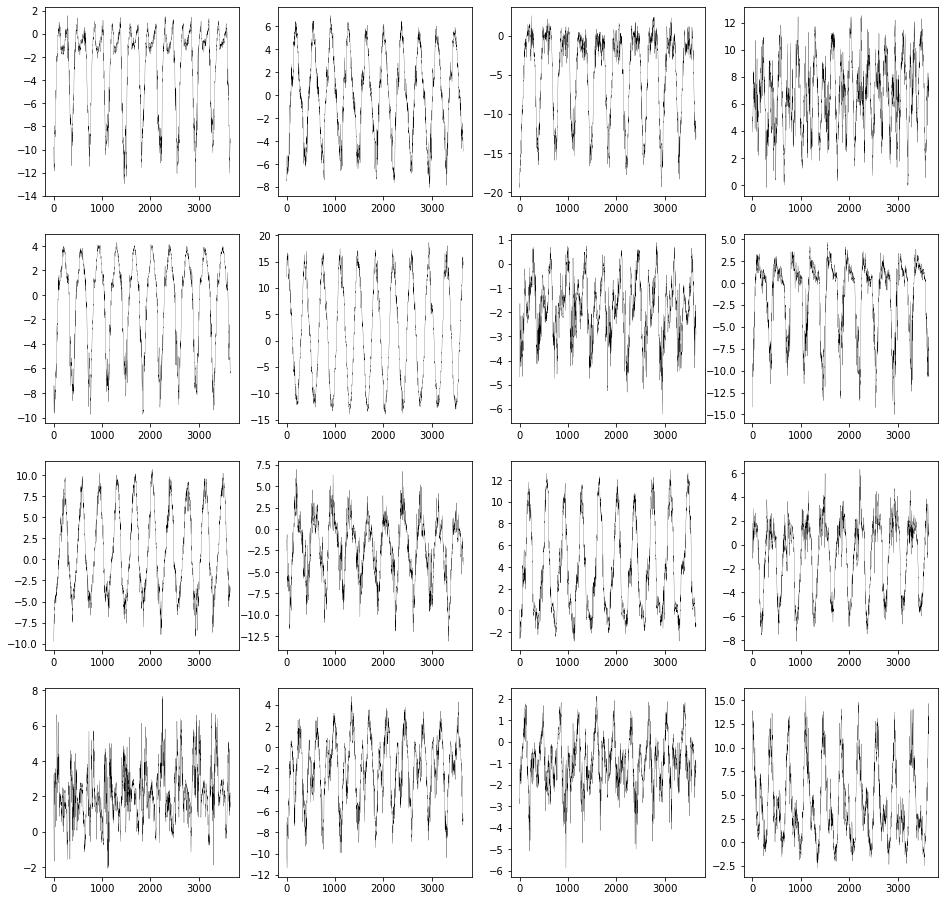

In [9]:
# start= 76*365
start= 0*365
# to_plot= projected[:4*365]
to_plot= embedding[start:start+10*365]

fig, ax = plt.subplots(nrows=math.ceil(b/4), ncols=4, figsize=(16,b))
for i in range(b):
#     print(i%3, int(i/4))
    ax[int(i/4), i%4].plot(to_plot[:,i], 'k', linewidth=.2)

In [111]:
non_zero = np.var(np.array(embedding),axis=0)>0.1

In [114]:
non_zero.sum()

28

[0.9848281  0.9848281  0.99112344 0.99112344 1.0031024  0.995891
 0.995891   0.9864664  0.9905699  0.9905699  0.9904711  0.9904711
 0.9920008  0.9920008  0.9882049  0.9882049  0.98331636 0.98331636
 0.98420197 0.98420197 0.9945903  0.9919578  0.9919578  0.98946226]


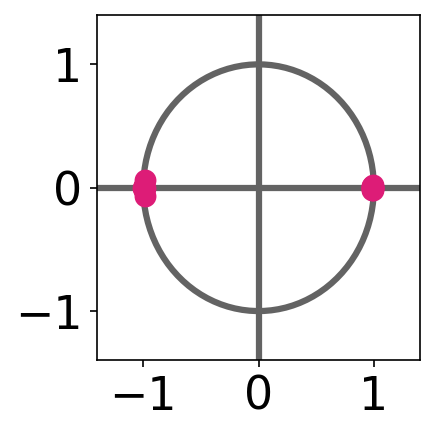

In [50]:
    #******************************************************************************
    # Eigenvalues
    #******************************************************************************
    model.eval()

    #if hasattr(model.dynamics, 'dynamics'):
    A =  model.dynamics.dynamics.weight.cpu().data.numpy()
    #A =  model.module.test.data.cpu().data.numpy()
    w, v = np.linalg.eig(A)
    print(np.abs(w))

    fig = plt.figure(figsize=(3, 3), facecolor="white",  edgecolor='k', dpi=150)
    plt.scatter(w.real, w.imag, c = '#dd1c77', marker = 'o', s=15*6, zorder=2, label='Eigenvalues')

    maxeig = 1.4
    plt.xlim([-maxeig, maxeig])
    plt.ylim([-maxeig, maxeig])
    plt.locator_params(axis='x',nbins=4)
    plt.locator_params(axis='y',nbins=4)

    #plt.xlabel('Real', fontsize=22)
    #plt.ylabel('Imaginary', fontsize=22)
    plt.tick_params(axis='y', labelsize=22)
    plt.tick_params(axis='x', labelsize=22)
    plt.axhline(y=0,color='#636363',ls='-', lw=3, zorder=1 )
    plt.axvline(x=0,color='#636363',ls='-', lw=3, zorder=1 )

    #plt.legend(loc="upper left", fontsize=16)
    t = np.linspace(0,np.pi*2,100)
    plt.plot(np.cos(t), np.sin(t), ls='-', lw=3, c = '#636363', zorder=1 )
    plt.tight_layout()
    plt.show()
    plt.close()

    plt.close('all')

In [279]:
np.angle(w)/np.pi

array([ 9.7641224e-01, -9.7641224e-01,  9.9486589e-01, -9.9486589e-01,
        9.9667752e-01, -9.9667752e-01,  9.9851018e-01, -9.9851018e-01,
        9.9971426e-01, -9.9971426e-01,  9.9973077e-01, -9.9973077e-01,
        6.9622928e-03, -6.9622928e-03,  0.0000000e+00,  2.9170753e-03,
       -2.9170753e-03,  3.0126562e-03, -3.0126562e-03,  0.0000000e+00,
        0.0000000e+00,  5.9229968e-04, -5.9229968e-04,  0.0000000e+00],
      dtype=float32)

In [12]:
len(train_data)

40178

In [13]:
type(train_data[:][0])

torch.Tensor

In [16]:
train_data[:][0][0].shape

torch.Size([1, 72, 144])

In [51]:
mean = torch.mean(torch.mean(torch.mean(train_data[:][0], axis=1),axis=1),axis=1)

## Compare reconstruction

In [91]:
train_data[:][0][0].shape

torch.Size([1, 144, 144])

In [93]:
np.array(train_data[:][0][0])[0][:72].shape

(72, 144)

In [16]:
import netCDF4
climate_file = netCDF4.Dataset('../../data/tas_ann_MPI-ESM-MR_rcp85_r1i1p1_g025.nc')

In [17]:
lats = np.array(climate_file.variables['lat'])[::int(1/scale)]
lons = np.array(climate_file.variables['lon'])[::int(1/scale)]

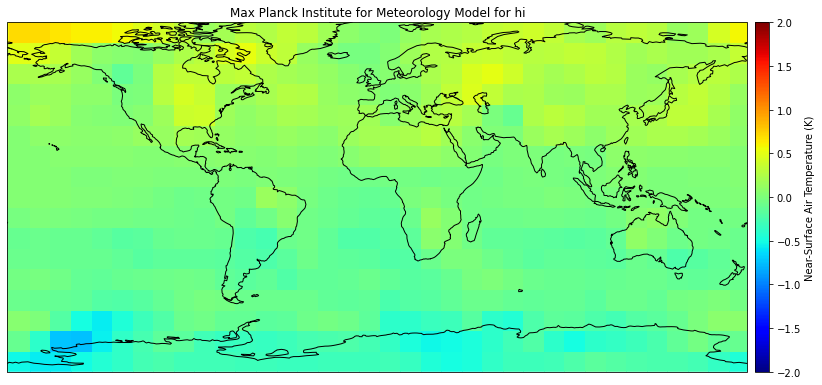

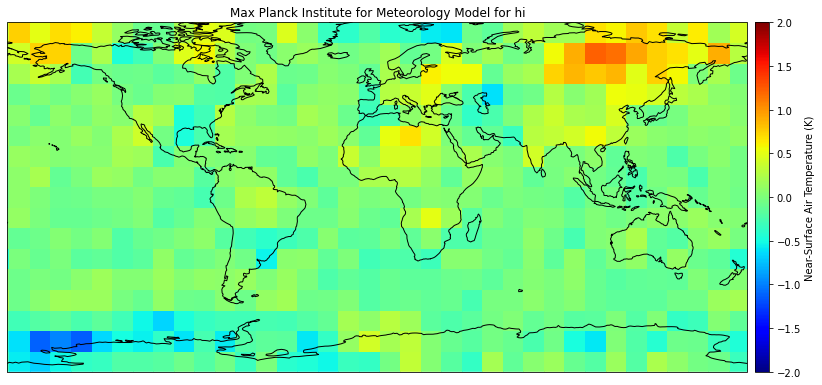

In [25]:
index =1000

with torch.no_grad():
    out, out_back = model(train_data[:][0][index:index +1])
    reconstruction = out[-1][0]



limit =int(72*scale)

plot_climate_data(temperature= np.array(train_data[:][0][index])[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-2, max_temp=2, savefile=False, filename=None)
plot_climate_data(temperature= np.array(reconstruction)[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-2, max_temp=2, savefile=False, filename=None)

if False:
    reconstruction_forward = out[0][0]
    reconstruction_forward2 = out[1][0]
    plot_climate_data(temperature= np.array(train_data[:][0][index +freq])[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-2, max_temp=2, savefile=False, filename=None)
    plot_climate_data(temperature= np.array(reconstruction_forward)[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-2, max_temp=2, savefile=False, filename=None)
    plot_climate_data(temperature= np.array(train_data[:][0][index + 2*freq])[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-2, max_temp=2, savefile=False, filename=None)
    plot_climate_data(temperature= np.array(reconstruction_forward2)[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-2, max_temp=2, savefile=False, filename=None)

    plot_climate_data(temperature= np.array(reconstruction_forward)[0][:limit] - np.array(reconstruction)[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-0.5, max_temp=0.5, savefile=False, filename=None)
    plot_climate_data(temperature= np.array(train_data[:][0][index + freq])[0][:limit] - np.array(train_data[:][0][index])[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-0.5, max_temp=0.5, savefile=False, filename=None)

In [224]:
np.array(reconstruction_forward2)[0]

array([[-0.00318271, -0.00076549, -0.00304498, ..., -0.0043342 ,
        -0.00463902, -0.00313249],
       [ 0.00238361, -0.00128422,  0.00282587, ...,  0.00203926,
        -0.00104515,  0.00037125],
       [-0.00109032, -0.00136732,  0.00285247, ...,  0.00091385,
         0.00061878, -0.00261519],
       ...,
       [ 0.00201057,  0.0030175 ,  0.00783203, ..., -0.00195522,
         0.00312627,  0.00050036],
       [ 0.00151684,  0.00316413,  0.00501444, ...,  0.00338816,
         0.00347363, -0.00593669],
       [ 0.01002446,  0.00693926,  0.00623682, ...,  0.00691448,
         0.00683182,  0.00057899]], dtype=float32)

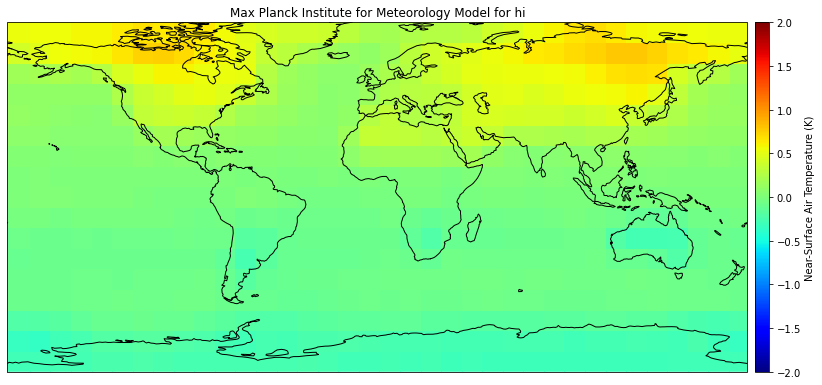

In [281]:
plot_climate_data(temperature= np.array(reconstruction_forward2)[0][:limit] ,lats=lats, lons=lons, timestamp="hi", min_temp=-2, max_temp=2, savefile=False, filename=None)

In [223]:
len(out)

13

In [226]:
reconstruction_forward2.shape

torch.Size([1, 36, 36])